# Quantum processor design

## Create a quantum processor

The foundation of our study is the quantum processor, composed of multiple qubits. We specifically focus on interaction terms involving two qubits, thereby simplifying the complexity of the system. The system Hamiltonian for our study is represented as:
$$
    H(t) = \sum_i H^{(1)}_{i} (t)  + \sum_{\langle i,j \rangle } H^{(2)}_{ij}(t),
$$
where $H^{(1)}_{i}$ and $H^{(2)}_{i,j}$ are single-qubit and two-qubit Hamiltonians respectively.

Analysis of superconducting qubits, in the context of circuit-QED theory, involves parameters like Josephson energy ($E_J$), charging energy ($E_C$), inductive energy ($E_L$), and coupling strengths ($g_C$, $g_L$). These parameters are pivotal in characterizing quantum processors in both simulation and experimental settings. In our work, some of these parameters are set as optimizing parameters.

We introduce a graph-based representation to describe the quantum processor. In this model, a graph is used where nodes represent qubits and edges symbolize the two-qubit interactions in the processor design. This representation allows for the mapping of various quantum processor designs to a graph. When users provide a processor design in this graphical format, SuperGrad efficiently converts the graph into a Haiku module, which then processes Hamiltonian parameters as function input.

This section also presents a concrete example of SuperGrad's implementation. We examine a 3-qubit chain consisting of three different fluxonium, configured such that the left and right pairs share the same coupling setup. Both capacitive and inductive couplings coexist in the nearest neighbors of this chain. The properties of each qubit and their couplings are managed using Python Dictionaries, which can also be exported as JSON files for further usage.

In [1]:
import numpy as np

fluxonium_1 = {
    "ec": 1.0 * 2 * np.pi,
    "ej": 4.0 * 2 * np.pi,
    "el": 0.9 * 2 * np.pi,
    "phiext": np.pi,
    "system_type": "fluxonium",
    "arguments": {"phi_max": 5 * np.pi},
}

fluxonium_2 = {
    "ec": 1.0 * 2 * np.pi,
    "ej": 4.0 * 2 * np.pi,
    "el": 1.0 * 2 * np.pi,
    "phiext": np.pi,
    "system_type": "fluxonium",
    "arguments": {"phi_max": 5 * np.pi},
}

fluxonium_3 = {
    "ec": 1.0 * 2 * np.pi,
    "ej": 4.0 * 2 * np.pi,
    "el": 1.1 * 2 * np.pi,
    "phiext": np.pi,
    "system_type": "fluxonium",
    "arguments": {"phi_max": 5 * np.pi},
}

coupling = {
    "capacitive_coupling": {
        "strength": 20e-3 * 2 * np.pi},
    "inductive_coupling": {
        "strength": -1.0 * 2e-3 * 2 * np.pi},
}


We now delve into the specifics of the dictionary structure used in our implementation. The Hamiltonian of a single qubit is written in the phase basis over a finite phase range, specifically chosen as $\varphi \in [-5\pi,5\pi]$. For our system, we select the qubit type as fluxonium and tune the external flux to bias the fluxonium at its sweetspot. In this study, we adopt the convention of assuming the reduced Planck constant $\hbar=1$. This assumption modifies our parameters by multiplying all Hamiltonian parameters with a factor of $2\pi$.

Building on this foundation, we conceptualize the topology of the quantum processor as a graph. This approach allows us to leverage the data structure and graph algorithms provided by NetworkX, a powerful Python library. As an illustrative example, we design a graph class containing comprehensive information about a 3-qubit processor. This class encapsulates the details of our quantum system, including the aforementioned Hamiltonian parameters and the qubit interactions, thus providing a convenience framework for analyzing and simulating quantum processor designs.

In [2]:
from supergrad.quantum_system.graph import BaseGraph

class MultipathThreeQubit(BaseGraph):
    def __init__(self):
        super().__init__()

        # nodes represent qubits
        self.add_node("q1", **fluxonium_1)
        self.add_node("q2", **fluxonium_2)
        self.add_node("q3", **fluxonium_3)
        # edges represent two-qubit interactions
        self.add_edge("q1", "q2", **coupling)
        self.add_edge("q2", "q3", **coupling)


In our approach, the JAX system plays a crucial role. It is designed to transform and compile pure functions, which take all data through parameters and return results via function output. To facilitate this, we have developed common functions for generating modules. In this context, a module is a Python class whose attributes are pure functions, each corresponding to different results.

To demonstrate the usage of these modules, we calculate the eigenenergies of the composite system and identify the dressed states. The result of the eigenenergy calculation is a tensor with $N$ indices, where each index corresponds to a label of the corresponding bare state.

For example, consider the following Python code snippet:

In [3]:
from supergrad.common_functions import Spectrum

chain_3q = MultipathThreeQubit()
spec = Spectrum(chain_3q, share_params=True, unify_coupling=True)
params = spec.static_params
energy = spec.energy_tensor(params)
dressed_freq_q1 = (energy[1, 0, 0] - energy[0, 0, 0])
dressed_freq_q2 = (energy[0, 1, 0] - energy[0, 0, 0])
print(dressed_freq_q1 / 2 / np.pi)
print(dressed_freq_q2 / 2 / np.pi)


0.49900235509866425
0.5821936219149919


where `spec.static_params` is a class property that extracts all the parameters from the graph. These parameters are then passed through as arguments to the pure functions. Users have the flexibility to write their own common functions for more advanced usage.

Exploring the behavior of quantum processors often involves multi-dimensional sweeps through different parameters. The `vmap` transformation in the JAX system enables the evaluation of functions on multiple sets of parameters in parallel. This feature provides an efficient method for addressing complex sweep problems. As an illustration, we analyze the static longitudinal coupling rate of the left qubit pair while keeping the right qubit in the ground state.

$$
\zeta_{ZZI} = \omega_{\ket{000}} + \omega_{\ket{110}} - \omega_{\ket{100}} - \omega_{\ket{010}}
$$

In [4]:
import jax
import jax.numpy as jnp

def compute_static_longitudinal_coupling(jc):
    chain_3q = MultipathThreeQubit()
    spec = Spectrum(chain_3q, share_params=True, unify_coupling=True)
    params = spec.static_params
    params["capacitive_coupling_all_unify"].update({"strength": jnp.array(jc)})
    energy = spec.energy_tensor(params)
    zeta_zzi = (
        energy[0, 0, 0] + energy[1, 1, 0] - energy[0, 1, 0] - energy[1, 0, 0]
    )
    return (zeta_zzi / 2 / np.pi * 1e6)**2

jc_sweep = jnp.linspace(0.0, 80e-3, 100)
zeta_sweep = jax.vmap(compute_static_longitudinal_coupling)(jc_sweep * 2 * jnp.pi)


In an ideal scenario, a quantum processor would maintain a uniform coupling configuration throughout, allowing optimization to focus on a single configuration. However, fabricating superconducting qubits with precise parameters is challenging, leading to variances in the final device parameters of the quantum processor. This variance means that couplings in different locations can have diverse impacts on the objective function. To address this, we implement a parameter sharing strategy, where each coupling is considered a function of the design parameters.

We define a vector-valued function $\mathbf{g}: \mathbb{R} \to \mathbb{R}^n$, where $n$ represents the number of couplings in the quantum processor. Within the context of parameter sharing, the gradient concerning the coupling parameter can be expressed as:

$$
    \frac{\partial O(\mathbf{g}(j))}{\partial j} = \frac{\partial O}{\partial \mathbf{g}} \cdot \frac{\partial \mathbf{g}}{\partial j}=\left( \frac{\partial O}{\partial g_1}, ..., \frac{\partial O}{\partial g_n}\right)\cdot \left( \begin{array}{c} \frac{\partial g_1}{\partial j}\\ ... \\ \frac{\partial g_n}{\partial j} \end{array}\right)
$$

where $g_i$ represents the local coupling parameters at each location, and $j$ is the design coupling parameter. Additionally, we propose a strategy to select a subset of qubits as prototypes, allowing every qubit in the quantum processor to share parameters with these prototypes.

In Haiku, parameter sharing is managed based on unique module instance names. In our approach, all qubits and couplings in the quantum processor are treated as copies of their corresponding prototypes. We can also modify the function $\mathbf{g}$ to simulate variances in parameters due to fabrication randomness. This variance can amount to a few percent of the parameter values. Recognizing and accommodating this unpredictable variance is critical, which is why our simulation of the quantum processor incorporates elements of randomness.

## Optimization via JAX system

The JAX system, with its just-in-time (JIT) compilation and automatic differentiation capabilities, enables efficient computation of both the value and the gradient of an objective function. Consequently, optimizing parameters becomes a more straightforward process. The integration of optimizers from machine learning backends like Optax into pure functions is seamless in this framework. Additionally, we have adapted the minimize function from SciPy, allowing both gradient-based methods (e.g., BFGS) and Hessian-based methods (e.g., Trust Region) to be executed using the JAX system.

In [5]:
from supergrad.utils.optimize import scipy_minimize

res = scipy_minimize(compute_static_longitudinal_coupling, 0.1, method='bfgs')
jc_opt = res.x / 2 / np.pi * 1000
print(jc_opt)
# 12.2496976


12.249697633740968


In this instance, we define the static ZZ in the left pair as the objective function. This function is pivotal for the entangling operation, and mitigating it helps reduce errors in both local and nonlocal operations. The multipath coupling approach recommends adding an inductive coupling term $-J_L\hat\varphi_A \hat\varphi_B$ to enable exchange interactions in the computational states, while optimizing the capacitive coupling term $J_C\hat n_A \hat n_B$ to suppress residual static ZZ. With an inductive coupling constant $J_L$ set at 2 MHz, we optimize the capacitive coupling constant to $J_C=12.25$ MHz, aiming for an approximate $|\zeta_{ZZ}|$ of zero.

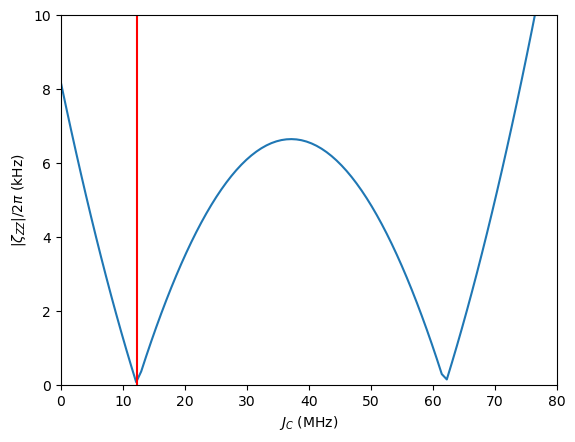

In [6]:
import matplotlib.pyplot as plt

plt.plot(jc_sweep * 1000, jnp.sqrt(zeta_sweep))
plt.xlabel(r"$J_C$ (MHz)")
plt.ylabel(r"$|\zeta_{ZZ}|/2\pi$ (kHz)")
plt.xlim(0, 80)
plt.ylim(0, 10)
plt.axvline(jc_opt, color='r')
plt.show()
